In [1]:
import sys
from agents.agent import DDPG_Agent
from tasks.task import Task
from tasks.takeoff_task import TakeOffTask
from plotter import Plotter
import numpy as np

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [32]:
# Modify the values below to give the quadcopter a different starting position.
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities

num_episodes = 100
target_pos = np.array([0., 0., 10.])
task = TakeOffTask(target_pos=target_pos)
agent = DDPG_Agent(task) 
avg_episode_rewards = []
episode_rewards = []

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done, is_learning = True)
        state = next_state
        if done:
            avg_episode_rewards.append(agent.score)
            episode_rewards.append(agent.total_reward)
            print("\rEpisode = {:4d}, avg_reward = {:7.3f}, reward = {:7.3f}".format(i_episode, agent.score, agent.total_reward), end="")
            break
    sys.stdout.flush()

Episode =   50, avg_reward =   0.836, reward = 209.764

KeyboardInterrupt: 

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

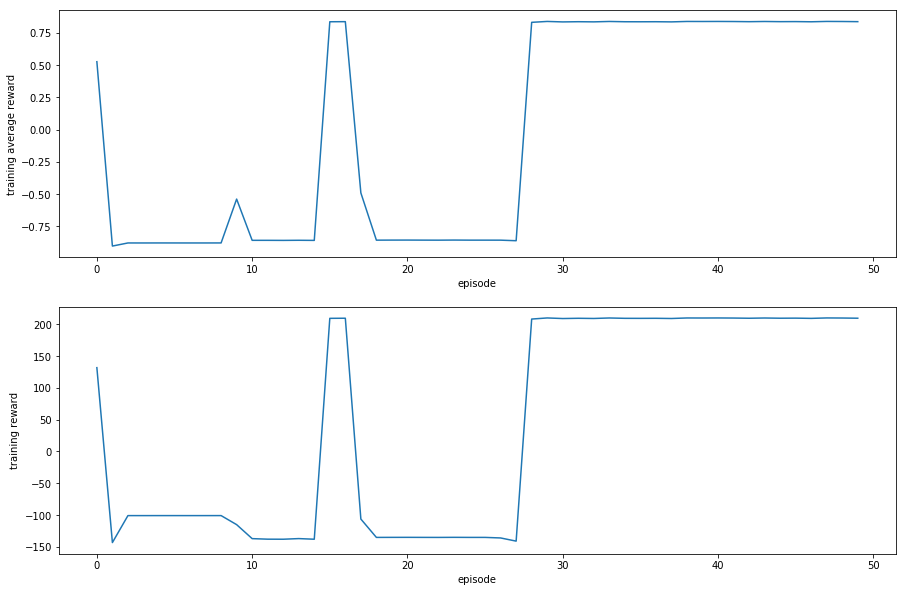

In [33]:
plt.subplots(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(avg_episode_rewards)
plt.xlabel('episode')
plt.ylabel('training average reward')

plt.subplot(2, 1, 2)
plt.plot(episode_rewards)
plt.xlabel('episode')
plt.ylabel('training reward')

plt.show()

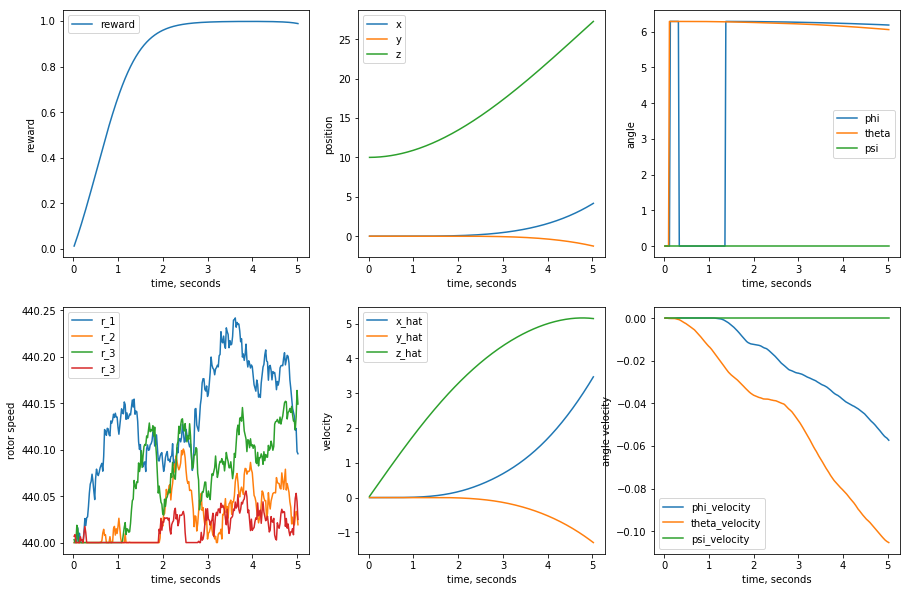

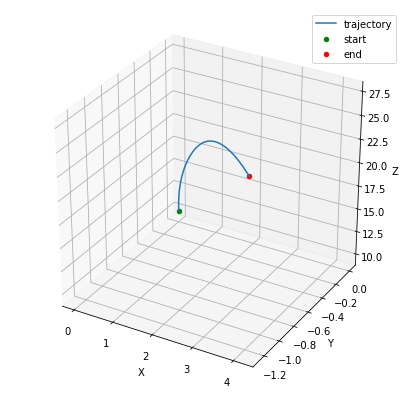

Start coordinates: x=  0.000 y=  0.000 z= 10.000
End coordinates: x=  4.167 y= -1.254 z= 27.254


In [34]:
state = agent.reset_episode() # start a new episode
plotter = Plotter()

while True:
    action = agent.act(state) 
    next_state, reward, done = task.step(action)
    
    # logging
    data_to_log = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward]
    plotter.add(data_to_log)
    
    agent.step(action, reward, next_state, done, is_learning=False)
    state = next_state
    if done:
        break
        
plotter.plot_all()
plotter.plot_trajectory()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**: